#  Analysis and synthesis of bell sounds with High resolution Methods

This notebook is an implementation of a signal processing course Practical work (provided by Roland Badeau)

This practical work aims to develop high resolution spectral estimation methods in order to perform analysis / synthesis of bell sounds. We'll show the limits of the spectral resolution of Fourier Transform in the context of bell sounds which are inharmonic instruments.

# Imports and GDrive mounting

In [1]:
import os, sys, wave, struct
import math
import scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

In [2]:
#============================= Connect to Drive ===============================#
from google.colab import drive
drive.mount('/content/gdrive/')
#==============================================================================#

Mounted at /content/gdrive/


In [3]:
cd /content/gdrive/MyDrive/"Audio signal processing for ML"/MVA

/content/gdrive/MyDrive/Audio signal processing for ML/MVA


# Useful functions

In [4]:
def load_sound(file):
    return wave.open(file, 'rb')

def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)

    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [5]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False:
        s = x
    else:
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b
    return s

# Visualizing and listening to bell sounds

We try to perform a analysis / synthesis of bell sounds. First, let's hear and see these bell sounds.

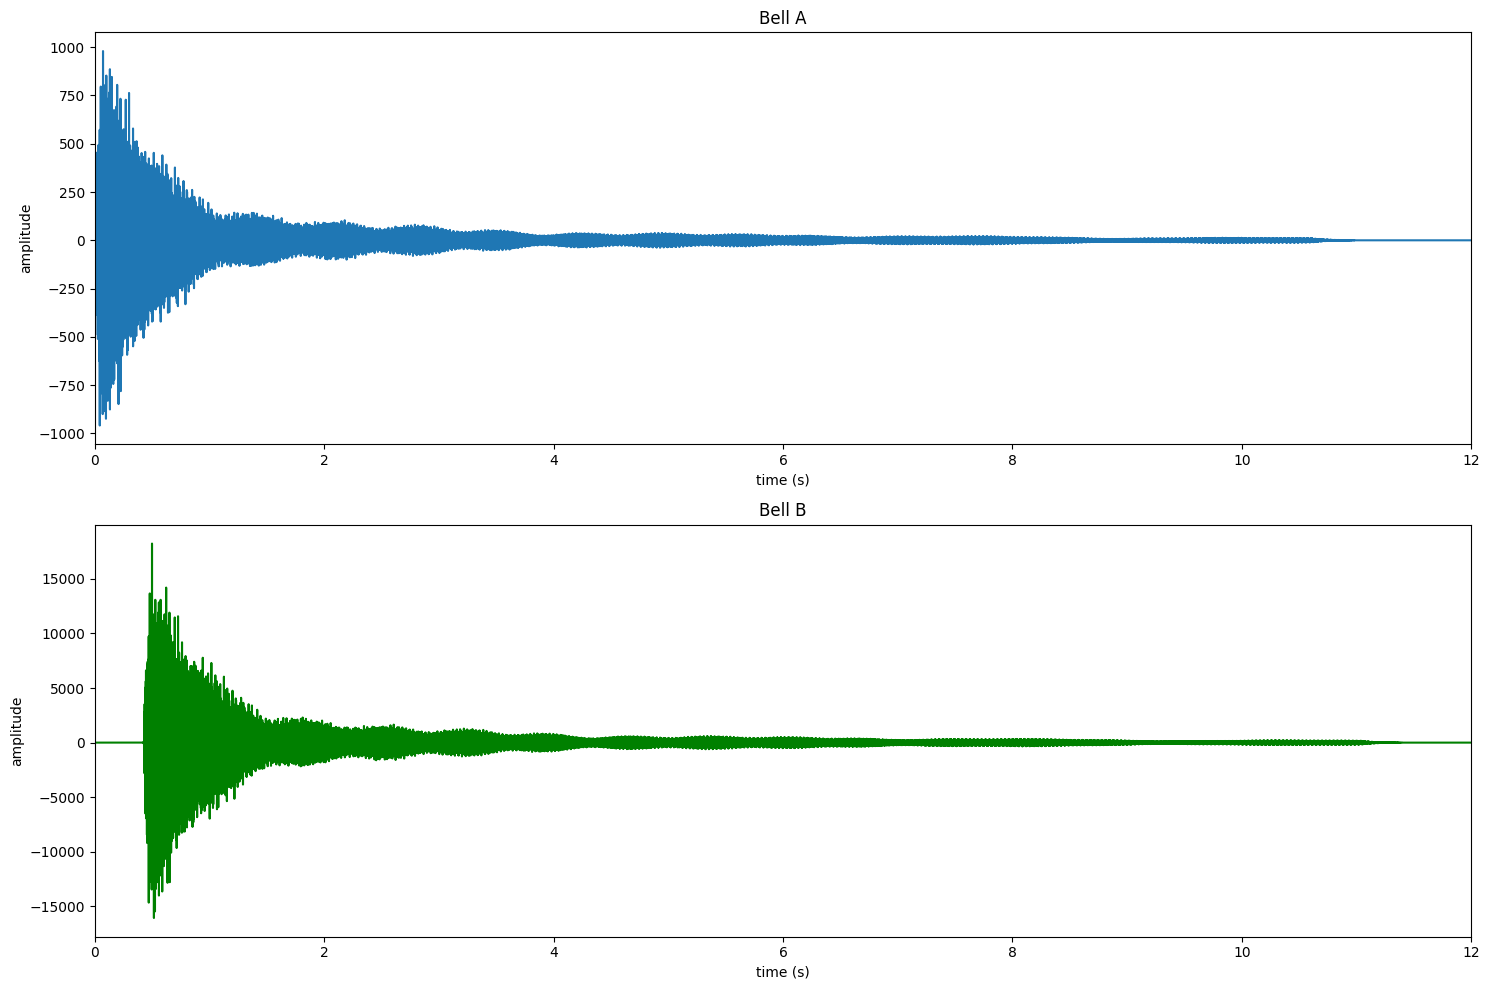

In [6]:
# Plot the 2 bell sounds
T_A, data_A, num_samples_A, nchannels_A, Fs_A = read_values('ClocheA.WAV')
T_B, data_B, num_samples_B, nchannels_B, Fs_B = read_values('ClocheB.WAV')

plt.figure(figsize=(15, 10))

# Plot Bell A
x = np.array(data_A)
len_x = x.shape[1]
timestep = 1/(float(Fs_A))
times = np.arange(len_x)*timestep

plt.subplot(2, 1, 1)
plt.plot(times, x.reshape(len_x))
plt.xlim(0, 12)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('Bell A')

# Plot Bell B
x = np.array(data_B)
len_x = x.shape[1]
timestep = 1/(float(Fs_B))
times = np.arange(len_x)*timestep

plt.subplot(2, 1, 2)
plt.plot(times, x.reshape(len_x), color='g')
plt.xlim(0, 12)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('Bell B')


plt.tight_layout()
plt.show()

In [7]:
IPython.display.Audio('ClocheA.WAV')

In [8]:
IPython.display.Audio('ClocheB.WAV')

# Synthetic signal

We first synthetise a signal with fixed length $N$, consisting of a sum of two complex exponentials, whose frequencies are given.  The phases are drawn randomly, according to a uniform probability distribution on $(−π, π)$.
We do not add noise to this signal, so that the observed signal $x[t]$ is equal to $s[t]$

In [9]:
N = 63

# frequencies
f0 = 1/4
f1 = f0 + 1/N
f = np.array([f0, f1])

# amplitudes
a0 = 1
a1 = 10
a = np.array([a0, a1])

# damping factors
delta0 = 0
delta1 = -0.05
delta = np.array([delta0, delta1])

#phases are drawn randomly, according to a uniform probability distribution
phi = np.random.uniform(low=-pi, high=pi, size=2)

# Synthetise signal x
x = Synthesis(N,delta,f,a,phi)

### Spectral analysis by Fourier transform

Let's compute and plot the periodogram of this signal. We try this without zero-padding and with zero-padding.

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


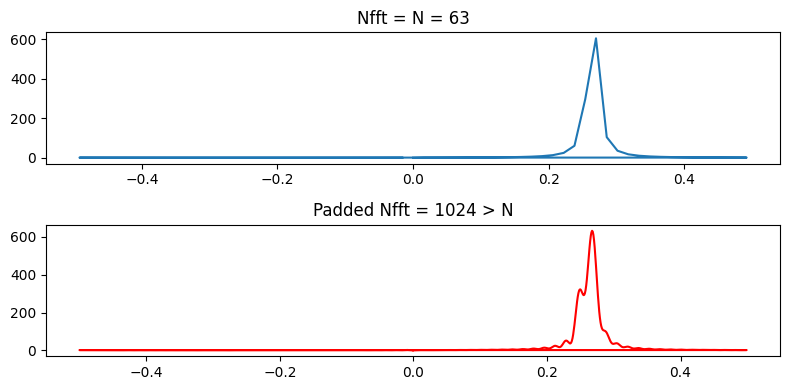

In [10]:
freq, Pxx = scipy.signal.periodogram(x)
freq_pad, Pxx_pad = scipy.signal.periodogram(x, nfft = 1024)

fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(freq, Pxx)
ax[0].set_title('Nfft = N = 63')
ax[1].plot(freq_pad, Pxx_pad, 'red')
ax[1].set_title('Padded Nfft = 1024 > N')
plt.tight_layout()
plt.show()

We see that zero-padding helps us to separate visually the two spectral lines of the signal. This is a result we could expect as the two frequencies are separated by an interval $∆f =1/N$. Thus we have a better frequency resolution. However, we could obtain more precise results with high resolution method.

# High resolution Methods

We define here some functions that are common to both ESPRIT and MUSIC methods.

First we need to compute the empirical covariance matrix :
$\hat{R}_{xx} = \frac{1}{l} XX^H$ where $X$ is the $n × l$ Hankel matrix containing the $N = n + l − 1$ samples of the signal:
$$X = \begin{bmatrix}
x[0] & x[1] & x[2] & \dots & x[l-1] \\
x[1] & x[2] & x[3] & \dots & x[l] \\
x[2] & x[3] & x[4] & \dots & x[l+1] \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
x[n-1] & x[n] & x[n+1] & \dots & x[N-1]
\end{bmatrix}$$


Then we need to find an estimation the signal ($span(W)$) and noise ($span(W_{\perp})$)  subspaces. To do that, we diagonalize the matrix $\hat{R}_{xx}$ (which is positive semi-definite). We have then $\hat{R}_{xx}=U_1 \Lambda U_1^H$ where $\Lambda$ is a diagonal matrix of eigenvalues sorted in decreasing order. We can prove that $\hat{R}_{xx}$ and thus $\Lambda$ is of rank $K$, so we can extract $(w_0, w_1, ..., w_{K-1})$ a basis of the signal subspace from $U_1$. Similarly, we can extract $(w_K, w_{K+1}, ..., w_{N-1})$ a basis of the noise subspace

In [11]:
n = 32
K = 2
l = N - n + 1

def empirical_covariance_matrix(x):
  X = hankel(x[:n], x[n-1:N])
  Rxx = np.dot(X,X.conj().T)/l
  return(Rxx)

def signal_subspace(Rxx):
  [U1,Lambda,U2] = scipy.linalg.svd(Rxx)
  return(U1[:, :K], U1[:, K:])


## ESPRIT Method

Now, with the estimation of the signal subspace we can implement the first stage of the ESPRIT Method which estimates the frequencies and the dumping factors. Here is what the code do :
- extract from $W$ the matrices $W_↓$ (resp. $W_↑$) obtained by removing the last (resp. first row of $W$)

- compute $\Phi = W_↓^\dagger W_↑$ where the symbol $\dagger$ denotes the pseudo inverse operator

- compute the eigenvalues of $\Phi$. These eigenvalues are the poles $z_k = e^{
\delta_k+i2π f_k}$. We can then deduce $\delta_k = ln(|z_k|)$ and $f_k =
\frac{1}{2π}angle(z_k)$.



In [12]:
def ESPRIT(x,n,K):
  Rxx = empirical_covariance_matrix(x)
  W, W_ortho = signal_subspace(Rxx)

  # Compute arrow W
  W_up = W[1:, :]
  W_down = W[: n-1, :]

  # Compute Phi
  Phi = np.dot(np.linalg.pinv(W_down), W_up)

  # Compute eigenvalues of Phi
  z = np.linalg.eig(Phi).eigenvalues

  # Deduce deltas and frequencies
  delta = np.log(np.abs(z))
  frequencies = np.angle(z)/(2*pi)

  return(delta, frequencies)

In [13]:
delta_hat, f_hat = ESPRIT(x,n,K)

The second part of the method aims to estimate the amplitudes $a_k$ and phases $\phi_k$ by means of the least squares method given the signal, the damping factors and the frequencies.

Let's define $V^N$ the $N×K$ Vandermonde matrix, where $V_{(t,k)}^N=z_k^t$,
 $\forall (t, k) \in \{0 . . . N − 1\} × \{0 . . . K − 1\}$.

The complex amplitudes are thus determined by the equation $$\alpha = V^{N^\dagger} x $$ where $x$ is the vector $[x[0], . . . , x[N−1]]^T$

Note that we can compute easily the Vandermonde matrix remarking that $ln(V^N)=[0,1,...,N]\times [\delta_0 + 2i\pi f_0, ..., \delta_{K-1} + 2i\pi f_{K-1}]^T$

In [14]:
def LeastSquares(x, delta, f):
  column = np.array([i for i in range(N)]).T
  line = delta + 2*1j*pi*f
  ln_Vandermonde = np.outer(column,line)
  alpha = np.linalg.pinv(np.exp(ln_Vandermonde)).dot(x)

  a = np.abs(alpha)
  phi = np.angle(alpha)
  return a, phi

In [15]:
a_hat, phi_hat = LeastSquares(x, delta_hat, f_hat)

In [16]:
print(f'Real parameters : \n delta ={delta} \n f={f} \n a={a} \n phi={phi}')

print(f'Estimated parameters :\n delta ={delta_hat} \n f={f_hat} \n a={a_hat} \n phi={phi_hat}')

Real parameters : 
 delta =[ 0.   -0.05] 
 f=[0.25       0.26587302] 
 a=[ 1 10] 
 phi=[2.83347017 2.45928512]
Estimated parameters :
 delta =[-5.0000000e-02  4.4408921e-16] 
 f=[0.26587302 0.25      ] 
 a=[10.  1.] 
 phi=[2.45928512 2.83347017]


Here with our synthetized signal we can see that the ESPRIT method is fairly good, giving us solid estimations of the real parameters of the signal.

## MUSIC Method

The MUSIC pseudo-spectrum is defined as $P(z) = \frac{1}{\| W_{\perp}^H \nu^n(z) \|^2}$
where matrix $W_{\perp}$ spans the noise subspace and $\nu^n(z) = [1, z, z^2, ..., z^{n-1}]^T$


Here, we want to make a 3D plot of $ln(P(z))$ as a function of $f\in[0,1]$ and $\delta\in[-0.1,0.1]$


In [17]:
def nu_n_z(delta, f, n):
  z = np.exp(delta + 2*1j*pi*f)
  return(np.array([z**i for i in range(n)]))

def pseudo_spectrum_log(delta, f, WH_ortho, n):
  return(-2*np.log(np.linalg.norm(WH_ortho.dot(nu_n_z(delta, f, n)))))

def MUSIC(x, n, K):
  Rxx = empirical_covariance_matrix(x)
  _ , W_ortho = signal_subspace(Rxx)

  f = np.arange(0, 1, 0.001)
  delta = np.arange(-0.1, 0.1, 0.001)
  WH_ortho = W_ortho.conj().T
  F, DELTA = np.meshgrid(f, delta)

  # Compute P(z) for each combination of f and delta
  P = np.array(F)
  for i in range(len(delta)):
      for j in range(len(f)):
          P[i, j] = pseudo_spectrum_log(DELTA[i, j], F[i, j], WH_ortho, n)

  # Find indices of the K highest peaks
  indices = np.unravel_index(np.argsort(P, axis=None)[-K:], P.shape)
  highest_peaks_F = F[indices]
  highest_peaks_DELTA = DELTA[indices]
  highest_peaks_P = P[indices]

  fig = plt.figure(figsize=(15, 10))
  # Two subplots with different angles for a better analysis
  for figure in range(2):
    ax = fig.add_subplot(1,2,figure+1, projection='3d')
    ax.plot_surface(F, DELTA, P, cmap="GnBu", alpha=0.6)
    ax.set_title(f'MUSIC Log pseudo-spectrum (view {figure+1})')

    # Highlight the peaks
    for i in range(K):
      ax.scatter(highest_peaks_F[i], highest_peaks_DELTA[i], highest_peaks_P[i], c='red', s= 15, alpha=1)

    # Change 'camera' angle
    if figure==1:
      ax.view_init(elev=10., azim=0)

    ax.set_xlabel('f')
    ax.set_ylabel('delta')
    ax.set_zlabel('P(z)')

  plt.show()
  return highest_peaks_F, highest_peaks_DELTA

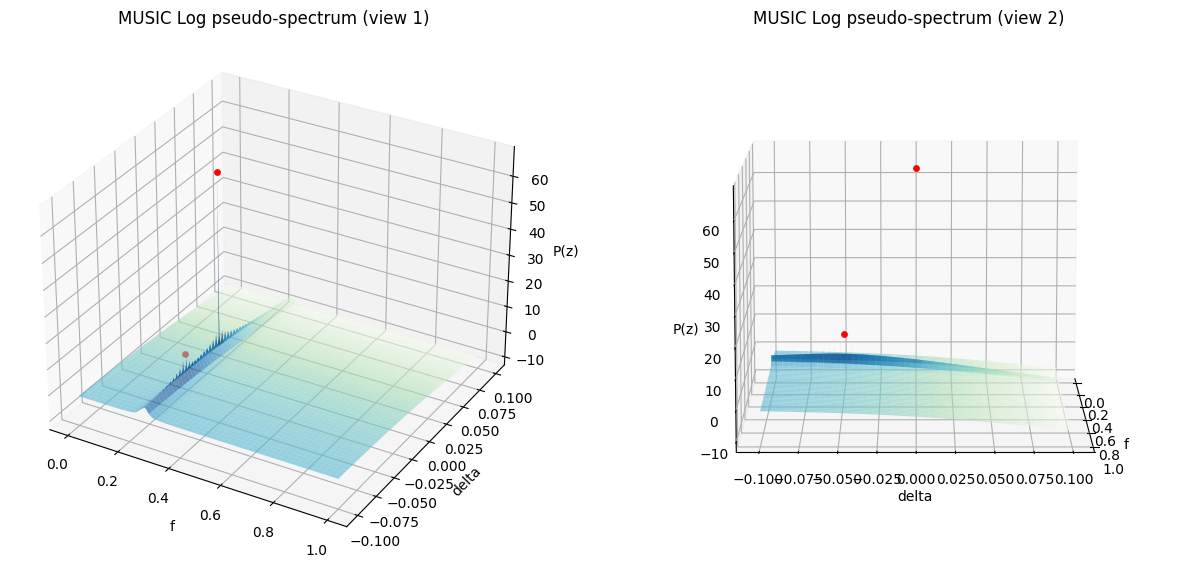

In [18]:
f_hat_music, delta_hat_music = MUSIC(x, 32, 2)

Here we clearly highlighted the K(=2) peaks of the MUSIC log pseudo-spectrum which corresponds to the K poles $z_k$ that should analytically be the only solutions to the equation $\| W_{\perp}^H \nu^n(z) \|=0$. When we retrieve the $z_k$ values and thus the $f_k$ and $\delta_k$ values, we get again satisfactory results that depend on the number of points we choose to compute P(z).

In [19]:
print(f'Real parameters : \n delta ={delta} \n f={f}')

print(f'Estimated parameters (MUSIC method) :\n delta ={delta_hat_music} \n f={f_hat_music}')

Real parameters : 
 delta =[ 0.   -0.05] 
 f=[0.25       0.26587302]
Estimated parameters (MUSIC method) :
 delta =[-5.00000000e-02  8.32667268e-17] 
 f=[0.266 0.25 ]


# Applying HR methods to Bell Audio Signals

## Spectral analysis with Fourier Transform

In [20]:
x_A = np.array(data_A)
x_B = np.array(data_B)


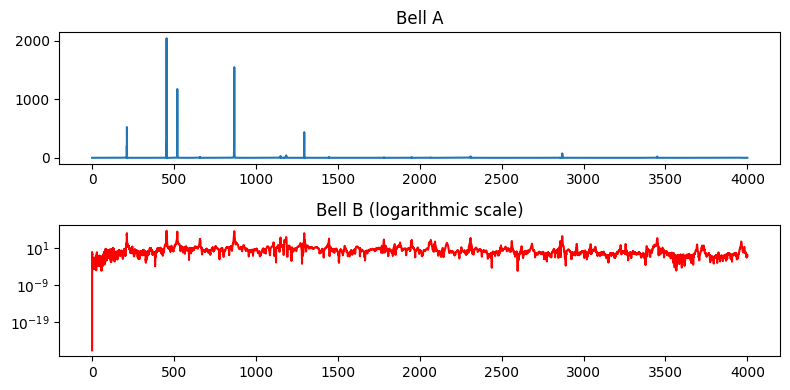

In [21]:
freq_A, Pxx_A = scipy.signal.periodogram(x_A, fs = Fs_A, nfft=120000) # we make sure to add zero-padding to increase a bit the frequency resolution
freq_A, Pxx_A = scipy.signal.periodogram(x_A, fs = Fs_A) # we make sure to add zero-padding to increase a bit the frequency resolution

freq_B, Pxx_B = scipy.signal.periodogram(x_B, fs = Fs_B, nfft=120000)

fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(freq_A, Pxx_A[0,:])
ax[0].set_title('Bell A')
ax[1].plot(freq_B, Pxx_B[0,:], 'red')
ax[1].set_title('Bell B (logarithmic scale)')
ax[1].set_yscale('log')
plt.tight_layout()
plt.show()

We try to gather (visually or with a computation) the eigenfrequencies (in the code there is language abuse of 'harmonics' as bell sound is higlhy inharmonic) corresponding to the frequencies with the most energy. When computing, we found out that having a threshold was giving us several very similar frequencies so we decided to group them and then compute the mean of each group.

In [22]:
def group(x, threshold):
  diff = x[1:]-x[:-1]
  gps = np.concatenate([[0],np.cumsum(diff>=threshold)])
  return [x[gps==i] for i in range(gps[-1]+1)]

# get the frequencies with an amplitude > threshold
def get_harmo(Pxx, freq, amplitude_threshold, freq_threshold):
  indices = np.where(Pxx[0, :] > amplitude_threshold)
  grouped_freq = group(freq[indices], freq_threshold)
  frequencies = np.array([np.mean(f) for f in grouped_freq])
  return frequencies


harmo_A = get_harmo(Pxx_A, freq_A, 10, 3)
harmo_B = get_harmo(Pxx_B, freq_B, 2500, 3)

print(harmo_A)
print(harmo_B)

[ 212.51497443  454.9711144   519.72457473  658.35390689  868.02712585
 1150.16094253 1184.32867694 1294.70712626 1446.25352876 2310.15552569
 2869.83968249 3450.0661479 ]
[ 212.50769231  454.97037037  519.73333333  658.36666667  868.06666667
 1150.16666667 1184.36666667 1294.7        1446.23333333 2310.16666667
 2869.83333333 3450.1       ]


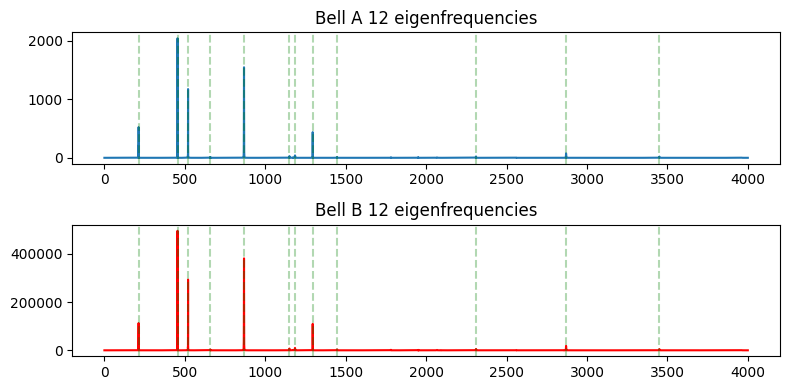

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(freq_A, Pxx_A[0,:])
for harmo in harmo_A:
  ax[0].axvline(harmo, c='green', linestyle='dashed', alpha = 0.3)
ax[0].set_title('Bell A 12 eigenfrequencies')
ax[1].plot(freq_B, Pxx_B[0,:], 'red')
for harmo in harmo_B:
  ax[1].axvline(harmo, c='green', linestyle='dashed', alpha = 0.3)
ax[1].set_title('Bell B 12 eigenfrequencies')
plt.tight_layout()
plt.show()

Let $f_p$ be the frequency corresponding to the perceived pitch. The analysis of the eigenfrequencies series leads to a table of about 15 ratios $\alpha_n = \frac{f_n}{f_p}$. Their orders of magnitude are as follows: 0.5 (hum
/ "bourdon"), 1 (prime / fundamental), 1.2 (minor third), 1.5 (fifth), 2 (nominal / octave), 2.5, 2.6, 2.7, 3,
3.3, 3.7, 4.2 (wrong double octave), 4.5, 5, 5.9. The timbre of the corresponding sound depends on the
amplitude and on the decrease of each of these partials

In [24]:
# real eigenfrequencies of a bell with perceived pitch frequency fp=455 Hz (if we look visually at our periodogram)
real_eigenfrequencies = []
ratios = [0.5, 1, 1.2, 1.5, 2, 2.5, 2.6, 2.7, 3, 3.3, 3.7, 4.2, 4.5, 5, 5.9]
for ratio in ratios:
  real_eigenfrequencies.append(ratio * 455)

print(real_eigenfrequencies)

[227.5, 455, 546.0, 682.5, 910, 1137.5, 1183.0, 1228.5, 1365, 1501.5, 1683.5, 1911.0, 2047.5, 2275, 2684.5]


We note that the frequencies corresponding to bell eigenfrequencies seems inexact when computed with Fourier Transform. Let's try a HR method for more precision.

## High resolution method

In [27]:
K = 54
n = 512
l = 1024
N = 1535

x_A = np.array(data_A)
x_B = np.array(data_B)

'''
Bell A
'''
# guarantee that the signal model holds on the analysis window
x_A = x_A[0,10000:10000+N]

# ESPRIT
delta_A, f_A = ESPRIT(x_A, n, K)
a_A, phi_A = LeastSquares(x_A, delta_A, f_A)

# Resynthetize the signal with the estimated parameters
resynth_x_A = Synthesis(10*N,delta_A,f_A,a_A,phi_A)


'''
Bell B
'''
# guarantee that the signal model holds on the analysis window
x_B = x_B[0,10000:10000+N]

# ESPRIT
delta_B, f_B = ESPRIT(x_B, n, K)
a_B, phi_B = LeastSquares(x_B, delta_B, f_B)

# Resynthetize the signal with the estimated parameters
resynth_x_B = Synthesis(10*N,delta_B,f_B,a_B,phi_B)



In [ ]:
# sort_indices = np.argsort(f_A)

# sorted_f_A = f_A[sort_indices]
# sorted_a_A = a_A[sort_indices]

# plt.plot(sorted_f_A, sorted_a_A)

In [ ]:
# eigenfreq_A = np.sort(f_A[f_A>0])
# print(eigenfreq_A)

In [ ]:
# # real eigenfrequencies of a bell with perceived pitch frequency fp=455 Hz (if we look visually at our periodogram)
# real_eigenfrequencies = []
# ratios = [0.5, 1, 1.2, 1.5, 2, 2.5, 2.6, 2.7, 3, 3.3, 3.7, 4.2, 4.5, 5, 5.9]
# for ratio in ratios:
#   real_eigenfrequencies.append(ratio * 0.26278427)

# print(np.array(real_eigenfrequencies) % 0.5)

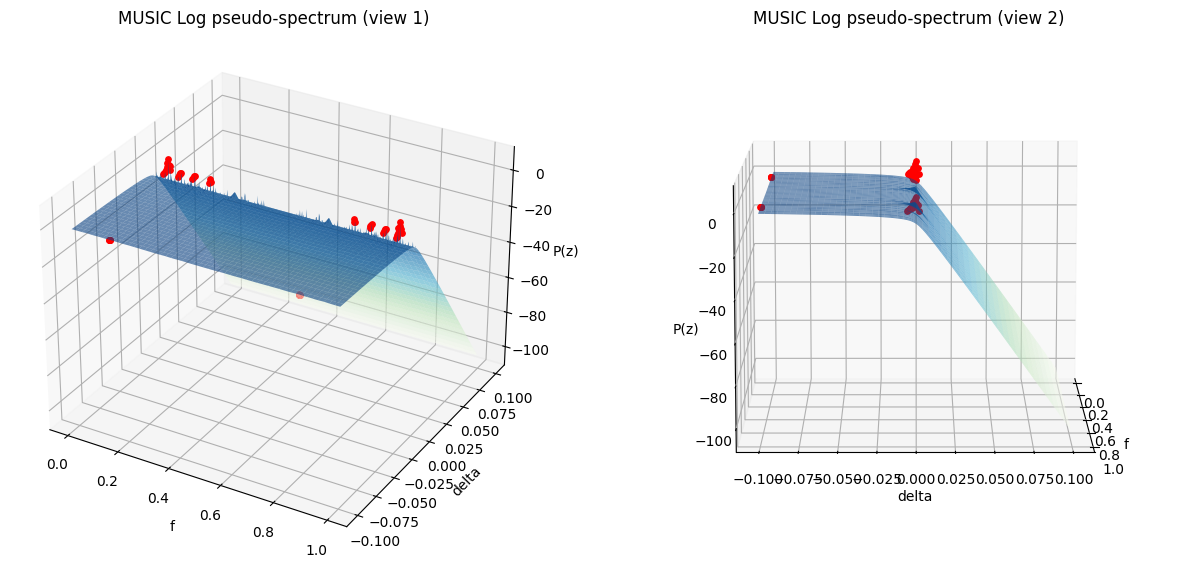

In [28]:
_ , _ = MUSIC(x_A, n, K)

In [29]:
write('new_bell_A.wav', Fs_A, np.array(resynth_x_A.reshape(10*N), dtype=np.int16)) # to write a new wave file

<ipython-input-29-da29b6faef49>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  write('new_bell_A.wav', Fs_A, np.array(resynth_x_A.reshape(10*N), dtype=np.int16)) # to write a new wave file
<ipython-input-29-da29b6faef49>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  write('new_bell_B.wav', Fs_B, np.array(resynth_x_B.reshape(10*N), dtype=np.int16)) # to write a new wave file


In [30]:
IPython.display.Audio('ClocheA.WAV')

In [31]:
IPython.display.Audio('new_bell_A.wav')

When we listen to the bell sound resynthetized with the parameters computed with ESPRIT, we can hear all the resonances and eigenfrequencies we hear in the base sound. Therefore we have reconstructed more efficiently the bell sound than with Fourier Transform.